In [17]:
import pandas as pd
import pyarrow.parquet as pq
from catboost import CatBoostClassifier
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data

#### prediction

In [3]:
target_prediction = pd.read_csv('./data/target_predicton.csv')
target_prediction_true = pd.read_csv('./data/target_predicton_true.csv')

In [4]:
# Результат прогнозирования бейзлайна (прогноз по срезу парка на 1 декабря 2022)
print(target_prediction.shape)
target_prediction.head()

(33977, 3)


,wagnum,target_month,target_day
0,33361,0,0
1,33364,1,1
2,33366,1,1
3,33358,0,0
4,33349,0,0


In [5]:
# Эталонные метки (для аналогичного периода)
print(target_prediction_true.shape)
target_prediction_true.head()

(33977, 3)


,wagnum,target_month,target_day
0,33361,0,0
1,33364,1,1
2,33366,1,1
3,33358,0,0
4,33349,0,0


In [6]:
from data.metrics_f1 import calc_f1_score
calc_f1_score(
    test_url='/home/rustem/projs/pgk/data/target_predicton_true.csv',
    prediction_url='/home/rustem/projs/pgk/data/target_predicton.csv'
)

0.23121339736861674

#### target

In [18]:
y_predict = pd.read_csv('./data/y_predict.csv')
y_predict_submit_example = pd.read_csv('./data/y_predict_submit_example.csv')

y_train = pd.read_csv('./data/y_train.csv')
y_train['month'] = y_train['month'].astype('datetime64[ns]')

In [8]:
# Номера вагонов и даты, по которым необходимо сделать предсказание.
# Приджойните к этому файлу ваши ответы и загрузите на платформу.
print(y_predict.shape)
y_predict.head()

(33707, 2)


,wagnum,month
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01


In [9]:
# Пример файла, который вы загрузите на платформу в качестве ответов.
print(y_predict_submit_example.shape)
y_predict_submit_example.head()

(33707, 4)


,wagnum,month,target_month,target_day
0,33361,2023-03-01,1,1
1,33364,2023-03-01,1,1
2,33366,2023-03-01,1,1
3,33358,2023-03-01,1,1
4,33349,2023-03-01,1,1


In [19]:
# Данные для обучения.
print(y_train.shape)
y_train.head()

(203853, 4)


,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0


In [20]:
y_train['month'].value_counts()

month
2022-12-01    33977
2022-09-01    33976
2022-10-01    33976
2022-11-01    33976
2022-08-01    33975
2023-01-01    33973
Name: count, dtype: int64

In [28]:
y_test = pd.read_csv('./data/feb/y_test.csv')
print(y_test.shape)
y_test.head()

(33708, 4)


,wagnum,month,target_month,target_day
0,33361,2023-02-01,0,0
1,33364,2023-02-01,0,0
2,33366,2023-02-01,0,0
3,33358,2023-02-01,0,0
4,33349,2023-02-01,0,0


#### parquet

In [2]:
dislok_wagons1 = pd.read_parquet(
    './data/dislok_wagons.parquet', engine='pyarrow')
dislok_wagons2 = pd.read_parquet(
    './data/feb/dislok_wagons.parquet', engine='pyarrow')
dislok_wagons = pd.concat([dislok_wagons1, dislok_wagons2])
del dislok_wagons1, dislok_wagons2
dislok_wagons = dislok_wagons.sort_values(by=['wagnum', 'plan_date'])

freight_info = pd.read_parquet('./data/freight_info.parquet', engine='pyarrow')

kti_izm = pd.read_parquet('./data/kti_izm.parquet', engine='pyarrow')
kti_izm['operation_date_dttm'] = kti_izm['operation_date_dttm'].astype('datetime64[ns]')

pr_rems = pd.read_parquet('./data/pr_rems.parquet', engine='pyarrow')
stations = pd.read_parquet('./data/stations.parquet', engine='pyarrow')
tr_rems = pd.read_parquet('./data/tr_rems.parquet', engine='pyarrow')
wag_params = pd.read_parquet('./data/wag_params.parquet', engine='pyarrow')
wagons_probeg_ownersip = pd.read_parquet('./data/wagons_probeg_ownersip.parquet', engine='pyarrow')

In [3]:
# Информация по дислокации
print(dislok_wagons.shape)
dislok_wagons.head()

(7228237, 16)


,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
17887,2022-08-01,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,82413,1,1671,1671,-1.0
17888,2022-08-02,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81744,1,1671,1671,-1.0
17889,2022-08-03,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81744,1,1671,1671,-1.0
17890,2022-08-04,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81462,1,1671,1671,-1.0
17891,2022-08-05,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81462,1,1671,1671,-1.0


In [15]:
# Список вагонов по которым известен пробег и тип владения на дату среза
print(wagons_probeg_ownersip.shape)
wagons_probeg_ownersip.head()

(6249857, 8)


,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8


In [16]:
# Справочник грузов
# (dislok_wagons -> fr_id)
print(freight_info.shape)
freight_info.head()

(5079, 9)


,fr_id,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,4989,2,0,0,0,0,0,0,0
1,4990,2,0,0,0,0,0,0,0
2,4991,0,0,0,0,0,0,0,0
3,4992,2,0,0,0,0,0,0,0
4,4993,2,0,0,0,0,0,0,0


In [17]:
# Данные по КТИ
# (dislok_wagons -> wagnum)
print(kti_izm.shape)
kti_izm.head()

(22428, 19)


,wagnum,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
43,1302,2023-02-17,67638.0,29.6,29.5,30.0,29.6,30.2,29.9,30.9,29.5,37.8,39.2,39.5,38.9,41.8,38.9,36.5,38.2
60,1374,2023-02-25,83798.0,29.1,27.9,27.7,29.1,29.3,30.2,29.4,27.5,48.9,49.0,49.7,51.0,30.7,32.4,30.6,28.8
137,2916,2023-02-21,121660.0,30.4,26.5,30.8,28.2,26.9,27.1,29.8,31.2,69.2,66.7,66.8,63.7,66.1,66.3,68.1,67.6
196,3849,2023-02-19,59664.0,30.6,29.2,31.6,28.5,31.0,30.7,29.3,30.0,75.1,76.1,74.8,73.7,75.6,76.8,72.2,72.9
197,3849,2023-02-20,59664.0,30.9,28.7,32.4,28.1,31.0,29.7,30.5,29.9,75.6,76.8,74.1,74.7,75.8,77.0,74.9,74.2


In [18]:
# Данные по плановым ремонтам
print(pr_rems.shape)
pr_rems.head()

(10441, 11)


,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37.0,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360.0,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322.0,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308.0,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373.0,8


In [19]:
# Справочник станций
print(stations.shape)
stations.head()

(148032, 9)


,st_id,road_id,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign
0,13069,47,0,0,0,0,0,0,0
1,9353,18,0,0,0,0,0,0,0
2,9973,19,0,0,0,0,0,1,0
3,13745,6,0,0,0,0,0,0,0
4,14554,15,0,0,0,0,0,0,0


In [20]:
# Данные по текущим ремонтам
print(tr_rems.shape)
tr_rems.head()

(48652, 17)


,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789


In [21]:
# Данные по характеристикам вагона
print(wag_params.shape)
wag_params.head()

(33977, 20)


,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1


## EDA

#### 1) Смотрим на периодичность данных в разрезе вагонов

<Axes: xlabel='wagnum,None'>

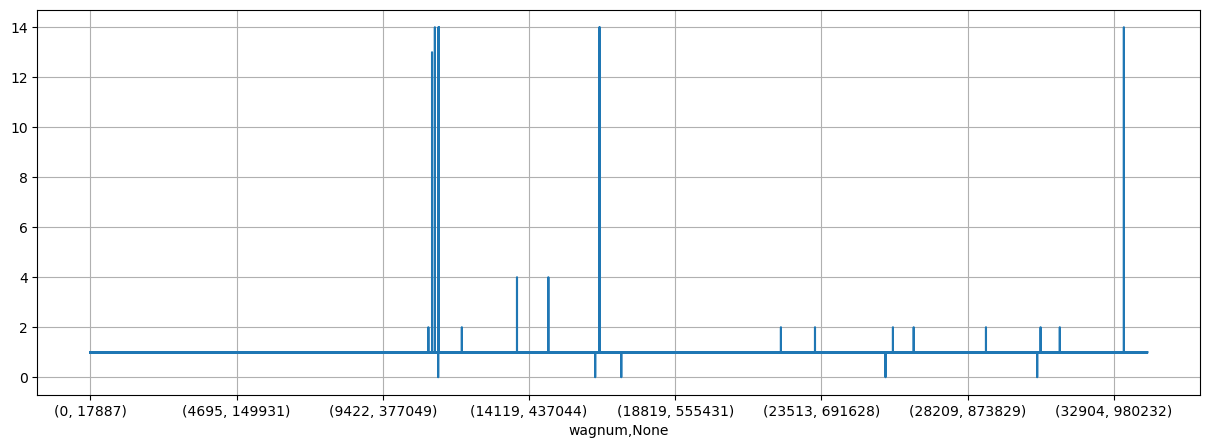

In [4]:
dislok_wagons.groupby('wagnum').apply(lambda df_: df_['plan_date'].diff()).dt.days.plot(figsize=(15, 5), grid=True)

#### 2) Смотрим на начальную и конечную даты в разрезе вагонов

In [5]:
# Распределение начальных дат по вагонам
dislok_wagons.groupby('wagnum')['plan_date'].min().value_counts()

plan_date
2022-08-01    33974
2022-09-01        1
2022-08-17        1
2022-11-14        1
Name: count, dtype: int64

In [6]:
# Распределение конечных дат по вагонам
dislok_wagons.groupby('wagnum')['plan_date'].max().value_counts()

plan_date
2023-03-01    33699
2023-01-31      264
2022-12-07        7
2022-12-31        2
2023-02-28        1
2023-01-25        1
2023-02-05        1
2022-12-22        1
2022-12-12        1
Name: count, dtype: int64

#### 3) Смотрим на размеры временных рядов в разрезе вагонов

In [7]:
dislok_wagons.groupby('wagnum').apply(lambda df_: df_.shape[0]).value_counts()

213    33681
184      264
212       10
109        7
219        3
210        2
182        1
178        1
185        1
189        1
153        1
217        1
144        1
134        1
218        1
48         1
Name: count, dtype: int64

## Dataset

#### Оставляем вагоны, временные ряды по которым начинаются с 2022-08-01 и заканчиваются 2023-03-01 с длительностю 213 наблюдения

In [9]:
target_wagons = dislok_wagons.groupby('wagnum').apply(
    lambda df_:
        (df_.iloc[0]['plan_date'] == pd.to_datetime('2022-08-01')) &\
            (df_.iloc[-1]['plan_date'] == pd.to_datetime('2023-03-01')) &\
                (df_.shape[0] == 213)
    )
target_wagons = target_wagons[target_wagons]

#### Оставляем наблюдения по соответствующим вагонам

In [10]:
dislok_wagons = dislok_wagons[
    dislok_wagons['wagnum'].isin(target_wagons.index.tolist())
    ]

#### Снова смотрим на периодичность наблюдений

<Axes: xlabel='wagnum,None'>

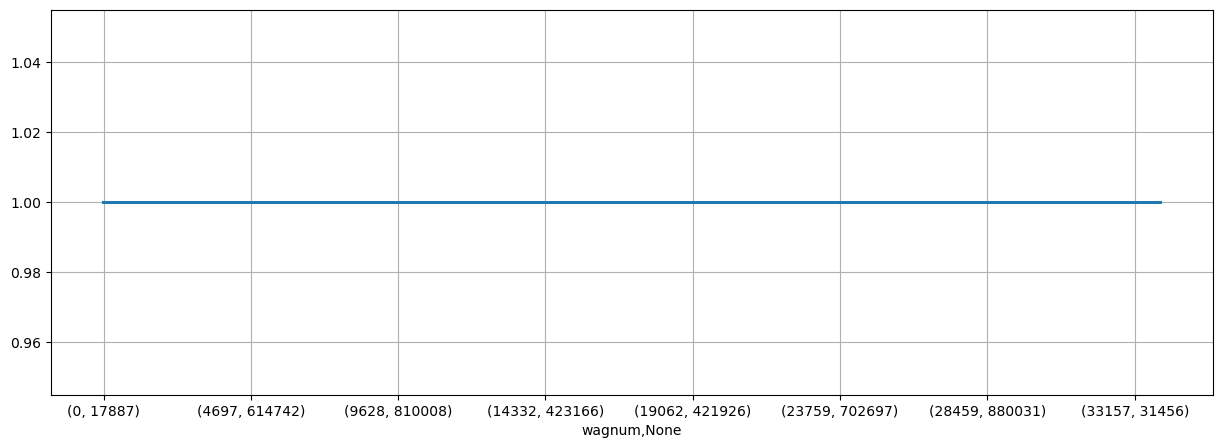

In [11]:
dislok_wagons.groupby('wagnum').apply(lambda df_: df_['plan_date'].diff()).dt.days.plot(figsize=(15, 5), grid=True)

#### Джойним таргет и обучаем CatBoost

НЕ АКТУАЛЬНО

Прогноз:  
по данным 01.01.2023-31.01.2023 - прогноз на 01.03.2023  
  
Обучаемся:  
данныe 01.12.2022-31.12.2022 - лейблы 01.02.2023  
данные 01.11.2022-30.11.2022 - лейблы 01.01.2023  
данные 01.10.2022-31.10.2022 - лейблы 01.12.2022  
данные 01.09.2022-30.09.2022 - лейблы 01.11.2022  
данные 01.08.2022-31.08.2022 - лейблы 01.10.2022  

In [25]:
dislok_wagons.head(2)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
17887,2022-08-01,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,82413,1,1671,1671,-1.0
17888,2022-08-02,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81744,1,1671,1671,-1.0


In [26]:
dislok_wagons['date_to_merge'] = dislok_wagons['plan_date'].map(
    lambda x:
        '2023-03-01' if x.month == 1\
        else '2023-02-01' if x.month == 12\
        else '2023-01-01' if x.month == 11\
        else '2022-12-01' if x.month == 10\
        else '2022-11-01' if x.month == 9\
        else '2022-10-01' if x.month == 8\
        else '1970-01-01'
)
dislok_wagons['date_to_merge'] = dislok_wagons['date_to_merge'].astype('datetime64[ns]')
dislok_wagons['days_to_predict'] = (dislok_wagons['date_to_merge'] - dislok_wagons['plan_date']).dt.days

In [27]:
dislok_wagons['ost_prob'] = dislok_wagons['ost_prob'].fillna(dislok_wagons['ost_prob'].median())

In [28]:
dislok_wagons = dislok_wagons.merge(
    right=y_train,
    left_on=['wagnum', 'date_to_merge'],
    right_on=['wagnum', 'month'],
    how='left' 
)

In [29]:
dislok_wagons = dislok_wagons.assign(
    plane_date_day=dislok_wagons['plan_date'].dt.day,
    plane_date_month=dislok_wagons['plan_date'].dt.month,
    plane_date_year=dislok_wagons['plan_date'].dt.year,
    plane_date_dayofweek=dislok_wagons['plan_date'].dt.day_of_week,

    date_kap_day=dislok_wagons['date_kap'].dt.day,
    date_kap_month=dislok_wagons['date_kap'].dt.month,
    date_kap_year=dislok_wagons['date_kap'].dt.year,
    date_kap_dayofweek=dislok_wagons['date_kap'].dt.day_of_week,
    
    date_dep_day=dislok_wagons['date_dep'].dt.day,
    date_dep_month=dislok_wagons['date_dep'].dt.month,
    date_dep_year=dislok_wagons['date_dep'].dt.year,
    date_dep_dayofweek=dislok_wagons['date_dep'].dt.day_of_week,
    
    date_pl_rem_day=dislok_wagons['date_pl_rem'].dt.day,
    date_pl_rem_month=dislok_wagons['date_pl_rem'].dt.month,
    date_pl_rem_year=dislok_wagons['date_pl_rem'].dt.year,
    date_pl_rem_dayofweek=dislok_wagons['date_pl_rem'].dt.day_of_week,
)

In [30]:
train = dislok_wagons[dislok_wagons['plan_date'] <= pd.to_datetime('2022-11-30')]

x_to_forecast_feb = dislok_wagons[
    (dislok_wagons['plan_date'] >= pd.to_datetime('2022-12-01')) & (dislok_wagons['plan_date'] <= pd.to_datetime('2022-12-31'))
    ]
x_to_forecast_mar = dislok_wagons[
    (dislok_wagons['plan_date'] >= pd.to_datetime('2023-01-01')) & (dislok_wagons['plan_date'] <= pd.to_datetime('2023-01-31'))
    ]

train = train.select_dtypes(exclude='datetime64[ns]')
x_to_forecast_feb = x_to_forecast_feb.select_dtypes(exclude='datetime64[ns]')
x_to_forecast_mar = x_to_forecast_mar.select_dtypes(exclude='datetime64[ns]')

del dislok_wagons


val = train.sample(frac=0.33, replace=False)
train = train.drop(val.index)
x_to_forecast_feb = x_to_forecast_feb.drop(['target_month', 'target_day'], axis=1)
x_to_forecast_mar = x_to_forecast_mar.drop(['target_month', 'target_day'], axis=1)

## CatBoost и kNN

#### target_month

In [31]:
train.head()

,wagnum,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance,days_to_predict,target_month,target_day,plane_date_day,plane_date_month,plane_date_year,plane_date_dayofweek,date_kap_day,date_kap_month,date_kap_year,date_kap_dayofweek,date_dep_day,date_dep_month,date_dep_year,date_dep_dayofweek,date_pl_rem_day,date_pl_rem_month,date_pl_rem_year,date_pl_rem_dayofweek
0,0,0,44,12202,44,11412,42,82413,1,1671,1671,-1.0,61,0.0,0.0,1,8,2022,0,5.0,8.0,2013.0,0.0,6.0,5.0,2020.0,2.0,6,5,2023,5
1,0,0,44,12202,44,11412,42,81744,1,1671,1671,-1.0,60,0.0,0.0,2,8,2022,1,5.0,8.0,2013.0,0.0,6.0,5.0,2020.0,2.0,6,5,2023,5
2,0,0,44,12202,44,11412,42,81744,1,1671,1671,-1.0,59,0.0,0.0,3,8,2022,2,5.0,8.0,2013.0,0.0,6.0,5.0,2020.0,2.0,6,5,2023,5
4,0,0,44,12202,44,11412,42,81462,1,1671,1671,-1.0,57,0.0,0.0,5,8,2022,4,5.0,8.0,2013.0,0.0,6.0,5.0,2020.0,2.0,6,5,2023,5
7,0,0,44,12202,44,11412,42,80930,1,1671,0,-1.0,54,0.0,0.0,8,8,2022,0,5.0,8.0,2013.0,0.0,6.0,5.0,2020.0,2.0,6,5,2023,5


In [32]:
x_train, y_train = train.drop(['target_month', 'target_day'], axis=1), train['target_month']
x_val, y_val = val.drop(['target_month', 'target_day'], axis=1), val['target_month']

In [33]:
categorical = [
    'wagnum', 'kod_vrab', 'id_road_disl', 'st_id_dest', 'id_road_dest',
    'st_id_send', 'id_road_send', 'fr_id', 'last_fr_id']

cat_month = CatBoostClassifier(
    iterations=100000,
    learning_rate=0.01,
    depth=5,
    early_stopping_rounds=200,
    use_best_model=True,
    verbose=100,
    task_type='GPU'
)
cat_month.fit(
    x_train, y_train,
    eval_set=(x_val, y_val)
)

cat_month.save_model(
    '/home/rustem/projs/pgk/models/cat_month.cbm',
    format='cbm'
)

0:	learn: 0.6654588	test: 0.6654483	best: 0.6654483 (0)	total: 29ms	remaining: 48m 20s
100:	learn: 0.1493587	test: 0.1488884	best: 0.1488884 (100)	total: 2.51s	remaining: 41m 26s
200:	learn: 0.1285146	test: 0.1279739	best: 0.1279739 (200)	total: 4.98s	remaining: 41m 11s
300:	learn: 0.1242951	test: 0.1237564	best: 0.1237564 (300)	total: 7.54s	remaining: 41m 35s
400:	learn: 0.1214980	test: 0.1209891	best: 0.1209891 (400)	total: 10.1s	remaining: 41m 51s
500:	learn: 0.1198503	test: 0.1193932	best: 0.1193932 (500)	total: 12.7s	remaining: 42m 6s
600:	learn: 0.1184251	test: 0.1180071	best: 0.1180071 (600)	total: 15.3s	remaining: 42m 13s
700:	learn: 0.1174051	test: 0.1170107	best: 0.1170107 (700)	total: 17.9s	remaining: 42m 18s
800:	learn: 0.1165754	test: 0.1162004	best: 0.1162004 (800)	total: 20.5s	remaining: 42m 17s
900:	learn: 0.1159070	test: 0.1155472	best: 0.1155472 (900)	total: 23.1s	remaining: 42m 18s
1000:	learn: 0.1152575	test: 0.1149206	best: 0.1149206 (1000)	total: 25.7s	remaining: 

In [35]:
cat_month = CatBoostClassifier()
cat_month.load_model(
    fname='/home/rustem/projs/pgk/models/cat_month.cbm'
)

<Axes: >

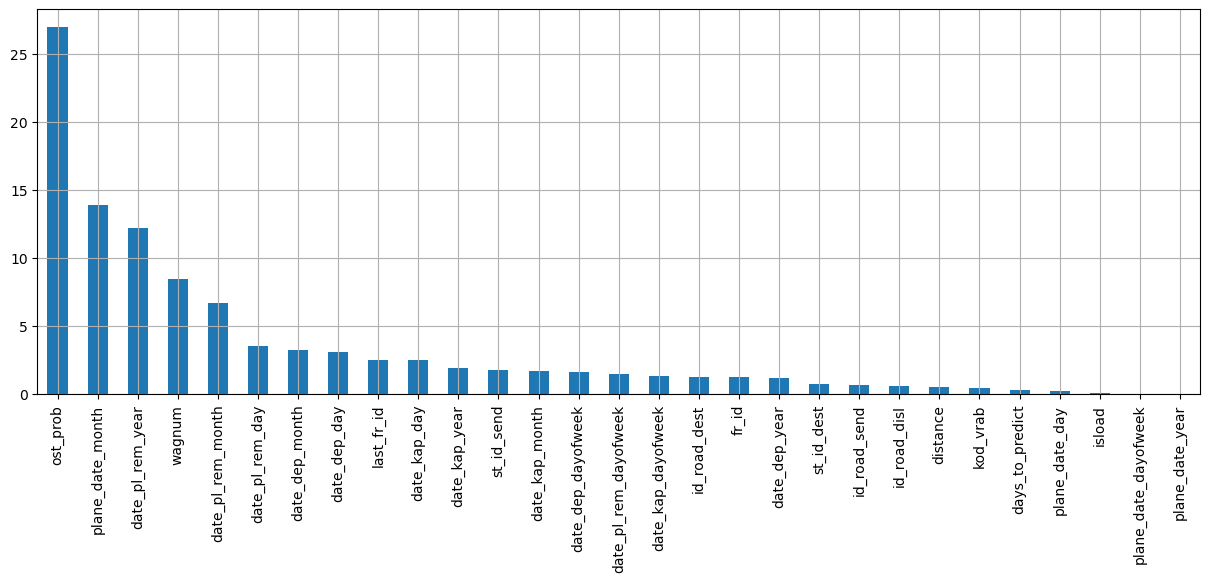

In [45]:
pd.Series(
    index=x_train.columns,
    data=cat_month.get_feature_importance()
).sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(15, 5))

In [47]:
y_hat = cat_month.predict(x_val)

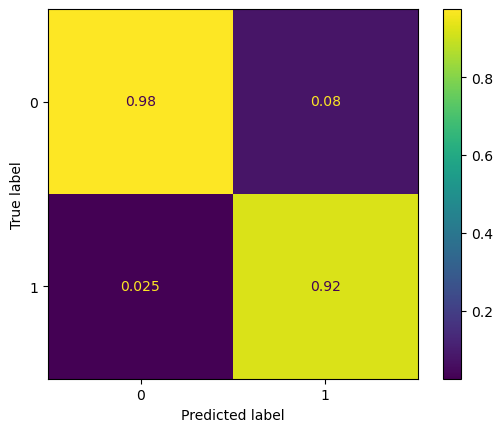

In [53]:
ConfusionMatrixDisplay(confusion_matrix(y_true=y_val, y_pred=y_hat, normalize='pred')).plot()